# Introdução

Nesse notebook vamos analisar os dados extraídos e modelar uma predição de qual direção o jogador batedor escolhe o seu pênalti

# Imports e EDA 

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
import joblib

In [4]:
df = pd.read_csv("data/pose_dataset.csv")

df.head()

,video,frame,label,timestamp_ms,f_0,f_1,f_2,f_3,f_4,f_5,...,f_89,f_90,f_91,f_92,f_93,f_94,f_95,f_96,f_97,f_98
0,cuts-penalty/-left_25.mp4,14,left,560,18.730248,6.722536,-17.994559,19.997099,7.363674,-19.619283,...,49.843681,-6.281641,-2.232804,31.542613,-2.733466,2.102156,50.944814,-6.639335,-1.556932,33.148179
1,cuts-penalty/-left_25.mp4,17,left,680,2.948408,1.116264,-2.223995,3.169540,1.230862,-2.298425,...,5.203326,-0.861973,-1.200678,1.890231,-0.064422,0.776065,5.683628,-1.413605,-0.907211,2.335429
2,cuts-penalty/-left_25.mp4,26,left,1040,-1.092117,-0.916257,1.262681,-1.189964,-1.083088,1.110757,...,0.332106,1.138850,1.290779,-0.354360,-0.738757,1.296990,0.411008,1.010591,1.483863,-0.401315
3,cuts-penalty/-left_25.mp4,27,left,1080,-1.541128,-1.230947,2.245118,-1.574265,-1.317240,2.046978,...,0.875108,1.852382,2.005341,-0.352920,-0.813314,1.992796,0.701307,1.516327,2.024874,-0.698502
4,cuts-penalty/-left_25.mp4,28,left,1120,-1.364228,-1.025184,1.540679,-1.375934,-1.107466,1.370645,...,0.319411,1.592479,1.616041,-1.057563,-0.371863,1.691750,0.491181,1.380972,1.684853,-1.141710


Vamos checar valores nulos ou NA

In [ ]:
print(np.sum(df.isna()),
    np.sum(df.isnull()))

0 0


Para facilitar nossas vidas, vamos pivotar o dataset

In [37]:
LANDMARK_NAMES = [
    'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer',
    'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 'mouth_left', 'mouth_right',
    'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow',
    'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky',
    'left_index', 'right_index', 'left_thumb', 'right_thumb',
    'left_hip', 'right_hip', 'left_knee', 'right_knee',
    'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
    'left_foot_index', 'right_foot_index'
]

def wide_to_long(df_wide):
    """
    Converte formato wide (99 colunas f_0 a f_98) 
    para long (body_part, x, y, z)
    """
    
    rows = []
    
    for idx, row in df_wide.iterrows():
        video = row['video']
        frame = row['frame']
        label = row['label']
        timestamp = row.get('timestamp_ms', None)
        
        # Para cada landmark (33 landmarks)
        for i, body_part in enumerate(LANDMARK_NAMES):
            x = row[f'f_{i*3}']      # f_0, f_3, f_6, ...
            y = row[f'f_{i*3 + 1}']  # f_1, f_4, f_7, ...
            z = row[f'f_{i*3 + 2}']  # f_2, f_5, f_8, ...
            
            rows.append({
                'video': video,
                'frame': frame,
                'label': label,
                'timestamp_ms': timestamp,
                'body_part': body_part,
                'x': x,
                'y': y,
                'z': z
            })
    
    return pd.DataFrame(rows)

df_long = wide_to_long(df)

df_long.head()

,video,frame,label,timestamp_ms,body_part,x,y,z
0,cuts-penalty/-left_25.mp4,14,left,560,nose,18.730248,6.722536,-17.994559
1,cuts-penalty/-left_25.mp4,14,left,560,left_eye_inner,19.997099,7.363674,-19.619283
2,cuts-penalty/-left_25.mp4,14,left,560,left_eye,19.969141,7.414006,-19.670668
3,cuts-penalty/-left_25.mp4,14,left,560,left_eye_outer,19.883675,7.473427,-19.663584
4,cuts-penalty/-left_25.mp4,14,left,560,right_eye_inner,20.276471,7.283757,-20.086377


Não possui valores nulos e nem NA

Rápida visualização de labels

Text(0.5, 0, 'Direção')

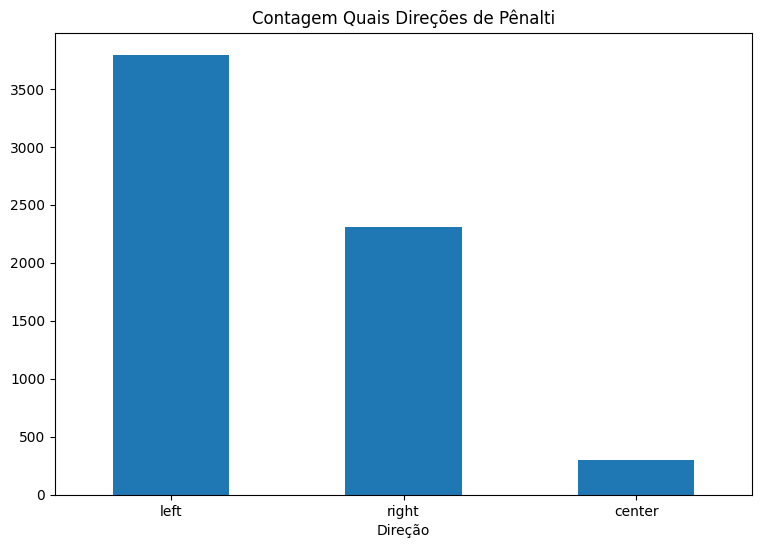

In [38]:
df_long["label"].value_counts().plot(kind = "bar", figsize = (9,6))
plt.title("Contagem Quais Direções de Pênalti")
plt.xticks(rotation = 0)
plt.xlabel("Direção")


Temos um variável target um tanto quanto mal distribuída em suas labels, temos que tomar cuidado ao treinar o modelo e introduzir um viés de cobertura (Subcobertura)

Vamos checar se existe correlação entre as coordenadas

Text(0.5, 1.0, 'Correlação entre coordenadas de landmarks')

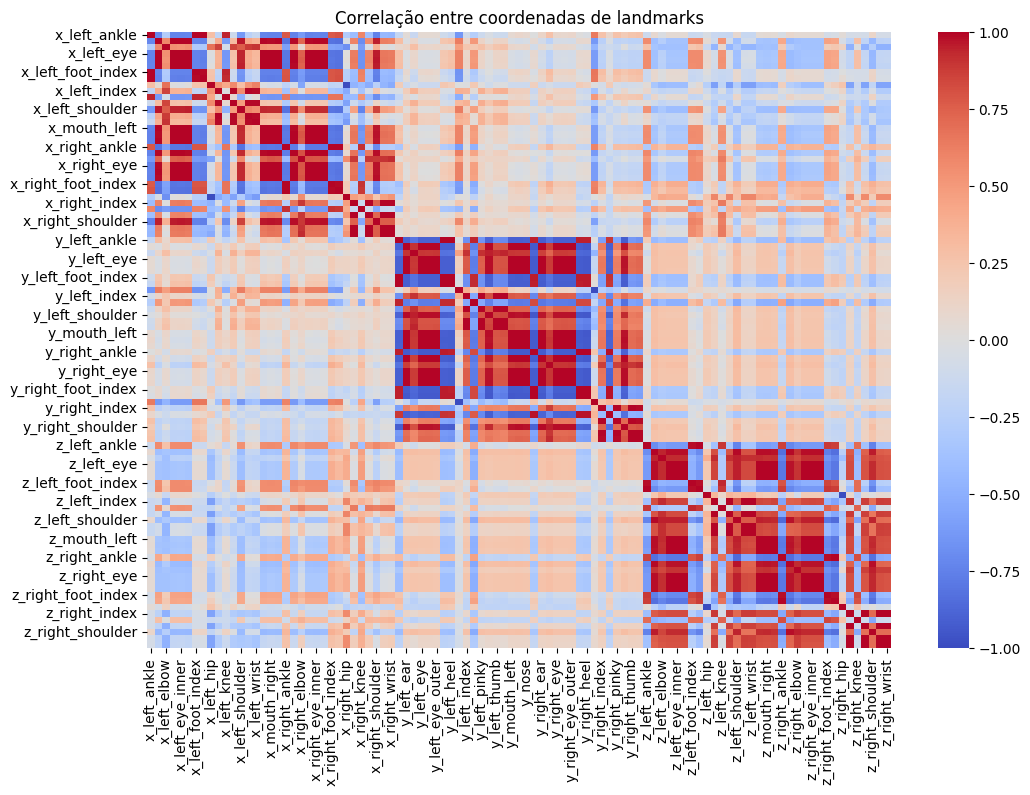

In [40]:
df_corr = df_long.pivot_table(
    index=['video', 'frame', 'label'],
    columns='body_part',
    values=['x','y','z']
)

df_corr.columns = [f"{axis}_{joint}" for axis, joint in df_corr.columns]
corr_matrix = df_corr.corr()

plt.figure(figsize = (12,8))

sns.heatmap(corr_matrix, cmap = "coolwarm", center = 0)
plt.title("Correlação entre coordenadas de landmarks")

O HEATMAP de correlação é esperado em dados de biomecânica com coordenadas.

Agora que temos essa ideia, vamos seguir com três possíveis caminhos:

 - Criação de novas features, como ângulo, velocidade e etc, um modelo só com essas features
 - PCA para reduzir dimensionalidade das coordenadas e um modelo só com essas features
 - Criação de novas features, como ângulo, velocidade e etc e um modelo com essas features mais as coordenadas brutas.

No mais, vamos continuar a EDA calculando estatísticas básicas dos joints

In [ ]:
for i in ["x", "y", "z"]:
    print(f"Média para coordenada {i}:")
    print(df_long[i].mean())
    print(f"Mediana para coordenada {i}:")
    print(df_long[i].median())
    print(f"Desvio Padrão para coordenada {i}:")
    print(df_long[i].std())
    print("="*70)

df.groupby("video").agg({"frame": "sum"})


Média para coordenada x:
0.14682999707168676
Mediana para coordenada x:
0.1408473379308228
Desvio Padrão para coordenada x:
1.9115515653646715
Média para coordenada y:
-0.25757610213145876
Mediana para coordenada y:
-0.18395102768452148
Desvio Padrão para coordenada y:
2.3490999975794624
Média para coordenada z:
-1.0720953452817905
Mediana para coordenada z:
-0.6546198418690394
Desvio Padrão para coordenada z:
4.237192039538579


,frame
video,
cuts-penalty/-center_02.mp4,619
cuts-penalty/-center_04.mp4,17
cuts-penalty/-center_13.mp4,34
cuts-penalty/-left_01.mp4,205
cuts-penalty/-left_02.mp4,895
cuts-penalty/-left_10.mp4,1445
cuts-penalty/-left_14.mp4,37
cuts-penalty/-left_15.mp4,21
cuts-penalty/-left_16.mp4,104


Médias negativas em coordenadas fazem sentido pois, foram normalizadas em relação ao ponto médio do quadril antes de salvar.

A diferença de tamanho dos vídeos pode ser um problema no futuro, nada tão alarmante.

vamos visualizar algumas distribuições

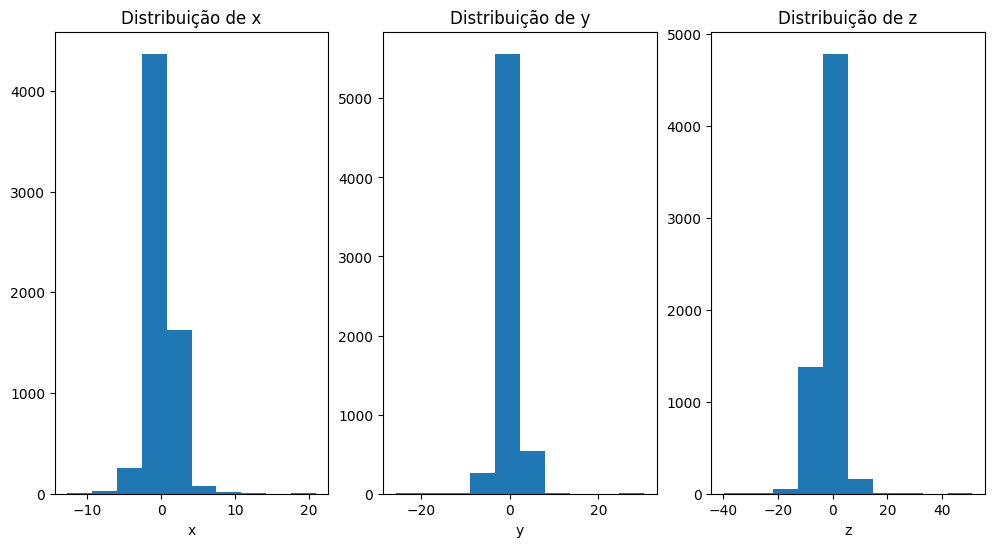

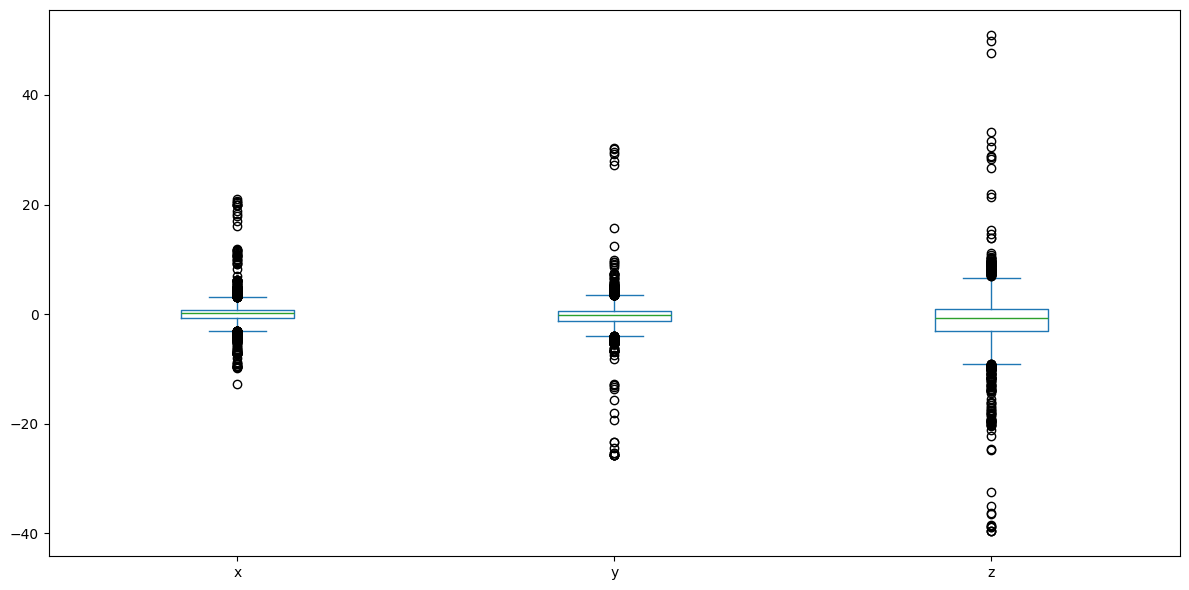

In [79]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

for i, col in enumerate(["x", "y", "z"]):
    ax[i].hist(df_long[col])
    ax[i].set_title(f'Distribuição de {col}') 
    ax[i].set_xlabel(col)


df_long[["x","y","z"]].plot(kind = "box", figsize = (12,6))


plt.tight_layout()

A distribuição das três coordenadas são bem iguais, já que foram normalizadas, mas é possível ver que a coordenada **z** possui valores maiores que as demais.

Fora isso, é possível notar que existem vários outliers.

Vamos entender a distribuição por label

🏆 TOP 15 FEATURES DISCRIMINATIVAS:
          body_part coord  discriminacao
62      right_index     z       6.448853
56      right_pinky     z       6.085696
59       left_index     z       5.774228
53       left_pinky     z       5.505024
68      right_thumb     z       5.439824
50      right_wrist     z       5.198126
65       left_thumb     z       4.856228
47       left_wrist     z       4.643901
2              nose     z       3.768840
11   left_eye_outer     z       3.749885
8          left_eye     z       3.749366
5    left_eye_inner     z       3.747744
17        right_eye     z       3.734393
20  right_eye_outer     z       3.734382
14  right_eye_inner     z       3.733859


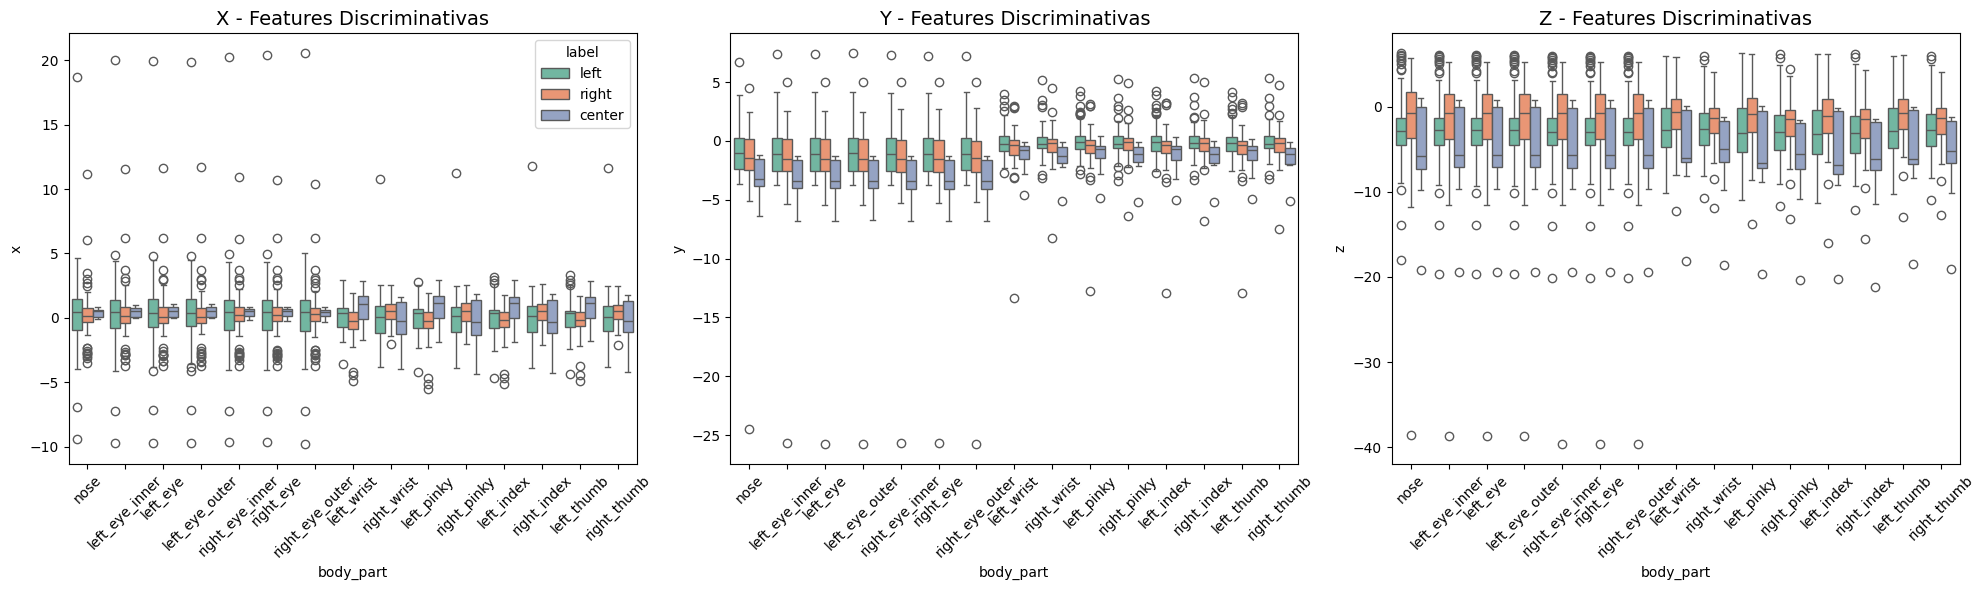

In [ ]:
def calcular_discriminacao(df_long):
    resultados = []
    for body_part in df_long.body_part.unique():
        df_part = df_long[df_long.body_part == body_part]
        for coord in ['x', 'y', 'z']:
            medias = df_part.groupby('label')[coord].mean()
            var_entre = medias.var()
            resultados.append({
                'body_part': body_part,
                'coord': coord,
                'discriminacao': var_entre
            })
    return pd.DataFrame(resultados)

df_disc = calcular_discriminacao(df_long)
top_15 = df_disc.nlargest(15, 'discriminacao')

print("🏆 TOP 15 FEATURES DISCRIMINATIVAS:")
print(top_15)

top_parts = top_15['body_part'].unique()
df_filtrado = df_long[df_long.body_part.isin(top_parts)]

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for i, coord in enumerate(['x', 'y', 'z']):
    sns.boxplot(
        data=df_filtrado,
        x='body_part',
        y=coord,
        hue='label',
        ax=axes[i],
        palette='Set2'
    )
    axes[i].set_title(f'{coord.upper()} - Features Discriminativas', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    if i > 0:
        axes[i].get_legend().remove()

plt.tight_layout()

Todas 15 top features são Z.

Quando o jogador chuta pra ESQUERDA:
 - Braço DIREITO vai pra frente (contrabalançar rotação)
 - Braço ESQUERDO vai pra trás
 - Mãos em Z positivo/negativo extremo

Quando chuta pra DIREITA:
 - Braço ESQUERDO vai pra frente
 - Braço DIREITO vai pra trás
 - Padrão OPOSTO

Quando chuta no CENTRO:
 - Braços mais simétricos
 - Mãos em Z mais neutro

# Feature Engineering

In [88]:
df_features = pd.DataFrame()

In [ ]:
def criar_features_essenciais(df_long, df_wide):
    """
    Cria apenas as features que realmente importam
    Baseado na análise discriminativa
    
    Parameters:
    -----------
    df_long : DataFrame
        Dataset no formato long (body_part, x, y, z)
    df_wide : DataFrame  
        Dataset original com f_0 até f_98
    """
    
    # Preparar dicionário de features
    features_dict = {}
    
    # Pegar cada body part necessária
    parts = {}
    for part in ['right_wrist', 'left_wrist', 'nose', 
                 'left_eye', 'right_eye', 
                 'right_shoulder', 'left_shoulder',
                 'right_hip', 'right_knee', 'right_ankle']:  # Adicionar pra ângulo
        parts[part] = df_long[df_long.body_part == part].reset_index(drop=True)
    
    # ============================================
    # 1. ASSIMETRIA DAS MÃOS (a mais importante!)
    # ============================================
    features_dict['assimetria_maos_z'] = (
        parts['right_wrist']['z'].values - 
        parts['left_wrist']['z'].values
    )
    
    features_dict['assimetria_maos_x'] = (
        parts['right_wrist']['x'].values - 
        parts['left_wrist']['x'].values
    )
    
    # ============================================
    # 2. POSIÇÃO MÉDIA DO CORPO
    # ============================================
    corpo_stats = df_long.groupby(['video', 'frame'])[['x', 'y', 'z']].agg(['mean', 'std'])
    
    features_dict['corpo_z_medio'] = corpo_stats[('z', 'mean')].values
    features_dict['corpo_y_medio'] = corpo_stats[('y', 'mean')].values
    
    # ============================================
    # 3. VARIÂNCIA DO MOVIMENTO (explosividade)
    # ============================================
    features_dict['variancia_z'] = corpo_stats[('z', 'std')].values
    features_dict['variancia_y'] = corpo_stats[('y', 'std')].values
    
    # ============================================
    # 4. DIREÇÃO DO OLHAR
    # ============================================
    eye_center_z = (
        parts['left_eye']['z'].values + 
        parts['right_eye']['z'].values
    ) / 2
    
    eye_center_x = (
        parts['left_eye']['x'].values + 
        parts['right_eye']['x'].values
    ) / 2
    
    features_dict['direcao_olhar_z'] = parts['nose']['z'].values - eye_center_z
    features_dict['direcao_olhar_x'] = parts['nose']['x'].values - eye_center_x
    
    # ============================================
    # 5. ROTAÇÃO DO TRONCO
    # ============================================
    features_dict['rotacao_tronco_z'] = (
        parts['right_shoulder']['z'].values - 
        parts['left_shoulder']['z'].values
    )
    
    features_dict['rotacao_tronco_x'] = (
        parts['right_shoulder']['x'].values - 
        parts['left_shoulder']['x'].values
    )
    
    # ============================================
    # 6. VELOCIDADE DAS MÃOS (NOVO!)
    # ============================================
    # Ordenar por vídeo e frame
    df_sorted = df_long.sort_values(['video', 'body_part', 'frame'])
    
    # Calcular velocidade (diferença entre frames consecutivos)
    for coord in ['x', 'y', 'z']:
        df_sorted[f'vel_{coord}'] = df_sorted.groupby(['video', 'body_part'])[coord].diff()
    
    # Velocidade da mão direita
    wrist_r_vel = df_sorted[df_sorted.body_part == 'right_wrist'].reset_index(drop=True)
    velocidade_mao_dir = np.sqrt(
        wrist_r_vel['vel_x']**2 + 
        wrist_r_vel['vel_y']**2 + 
        wrist_r_vel['vel_z']**2
    )
    features_dict['velocidade_mao_direita'] = velocidade_mao_dir.fillna(0).values
    
    # Velocidade da mão esquerda
    wrist_l_vel = df_sorted[df_sorted.body_part == 'left_wrist'].reset_index(drop=True)
    velocidade_mao_esq = np.sqrt(
        wrist_l_vel['vel_x']**2 + 
        wrist_l_vel['vel_y']**2 + 
        wrist_l_vel['vel_z']**2
    )
    features_dict['velocidade_mao_esquerda'] = velocidade_mao_esq.fillna(0).values
    
    # ============================================
    # 7. ÂNGULO DO JOELHO (NOVO!)
    # ============================================
    def calcular_angulo_vetores(p1, p2, p3):
        """
        Calcula ângulo entre 3 pontos (p1-p2-p3)
        p2 é o vértice do ângulo
        """
        v1 = p1 - p2
        v2 = p3 - p2
        
        # Evitar divisão por zero
        norm1 = np.linalg.norm(v1, axis=1, keepdims=True)
        norm2 = np.linalg.norm(v2, axis=1, keepdims=True)
        
        norm1 = np.where(norm1 == 0, 1e-6, norm1)
        norm2 = np.where(norm2 == 0, 1e-6, norm2)
        
        # Cosseno do ângulo
        cos_angle = np.sum(v1 * v2, axis=1) / (norm1.flatten() * norm2.flatten())
        cos_angle = np.clip(cos_angle, -1, 1)
        
        # Ângulo em radianos
        angles = np.arccos(cos_angle)
        return angles
    
    # Pegar coordenadas dos 3 pontos (quadril, joelho, tornozelo)
    hip = parts['right_hip'][['x', 'y', 'z']].values
    knee = parts['right_knee'][['x', 'y', 'z']].values
    ankle = parts['right_ankle'][['x', 'y', 'z']].values
    
    features_dict['angulo_joelho_direito'] = calcular_angulo_vetores(hip, knee, ankle)
    
    # ============================================
    # 8. ADICIONAR COORDENADAS ORIGINAIS (f_0 até f_98)
    # ============================================
    # Resetar índice do df_wide pra garantir alinhamento
    df_wide_reset = df_wide.reset_index(drop=True)
    
    # Pegar todas as colunas f_
    coord_cols = [f'f_{i}' for i in range(99)]
    
    for col in coord_cols:
        features_dict[col] = df_wide_reset[col].values
    
    # Converter pra DataFrame
    df_features = pd.DataFrame(features_dict)
    
    # Adicionar índices originais
    df_features['video'] = parts['nose']['video'].values
    df_features['frame'] = parts['nose']['frame'].values
    df_features['label'] = parts['nose']['label'].values
    
    return df_features


df_features = criar_features_essenciais(df_long, df)
# Salvar
df_features.to_csv('data/features_essenciais.csv', index=False)

✅ Features criadas: (194, 115)
   - Features engineered: 13
   - Coordenadas originais: 99
   - Total: 112 features (+ video, frame, label)

📊 Primeiras linhas:
   assimetria_maos_z  assimetria_maos_x  corpo_z_medio  corpo_y_medio  \
0           0.331134           7.830582      -3.993964      -0.827505   
1          -2.626410          -0.265337       0.039798      -0.437434   
2           1.854877          -0.340405       0.349469      -0.505234   
3           0.776438           0.343053      -3.245406      -0.933273   
4           1.185715           0.436490      -5.283980      -1.034151   

   variancia_z  variancia_y  direcao_olhar_z  direcao_olhar_x  \
0     4.294284     2.751369         1.912139        -1.457441   
1     1.182946     1.191337         0.095992        -0.228121   
2     1.163364     1.399389         0.079638         0.029568   
3     3.246188     3.273934         0.118820         0.010577   
4     5.109079     4.120862         0.101974        -0.007204   

   rotaca

# Training

In [112]:
X = df_features.drop(columns = ["video", "frame", "label"])
Y = df_features["label"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size = .2, random_state = 27, stratify = y_encoded)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled =  scaler.transform(X_test)

smote = SMOTE(random_state=27, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


param_grid = {
    'hidden_layer_sizes': [
        (64, 32),          
        (128, 64),          
        (128, 64, 32),      
        (256, 128, 64),     
    ],
    'alpha': [0.0001, 0.001, 0.01],          
    'learning_rate_init': [0.001, 0.01],     
    'batch_size': [32, 64, 'auto'],       
}


mlp = MLPClassifier(
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=27,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    verbose=False
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,       
    verbose=2,      
    return_train_score=True
)


grid_search.fit(X_train_resampled, y_train_resampled)

print(f"\n{'='*70}")
print(f"MELHORES HIPERPARÂMETROS:")
print(f"{'='*70}")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\nSCORES:")
print(f"   Best CV Score: {grid_search.best_score_:.4f}")
print(f"   Test Accuracy: {grid_search.score(X_test_scaled, y_test):.4f}")



Fitting 5 folds for each of 72 candidates, totalling 360 fits


0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0

[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   0.1s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   0.2s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   0.1s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   0.1s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   0.3s
[CV] END alpha=0.0001, batch_size=32, hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=  


TOP 5 CONFIGURAÇÕES:

Rank 1:
   Params: {'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.001}
   CV Score: 0.8734 (+/- 0.0390)

Rank 2:
   Params: {'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
   CV Score: 0.8732 (+/- 0.0254)

Rank 3:
   Params: {'alpha': 0.01, 'batch_size': 32, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
   CV Score: 0.8697 (+/- 0.0400)

Rank 4:
   Params: {'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.01}
   CV Score: 0.8625 (+/- 0.0473)

Rank 5:
   Params: {'alpha': 0.001, 'batch_size': 32, 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.01}
   CV Score: 0.8623 (+/- 0.0439)

Treinando modelo FINAL com melhores hiperparâmetros...
Iteration 1, loss = 1.16700366
Validation score: 0.562500
Iteration 2, loss = 0.77777413
Validation score: 0.500000
Iteration 3, loss = 0.65969995
Validation score: 0.500000
I

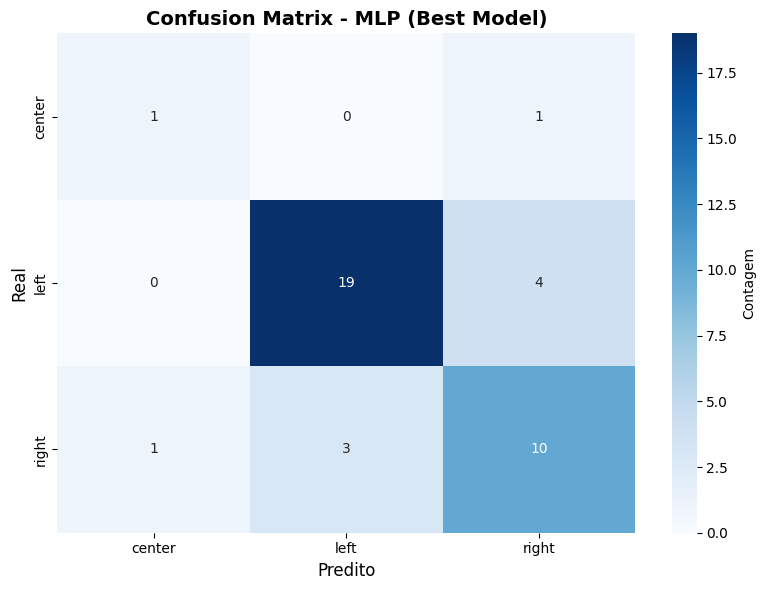

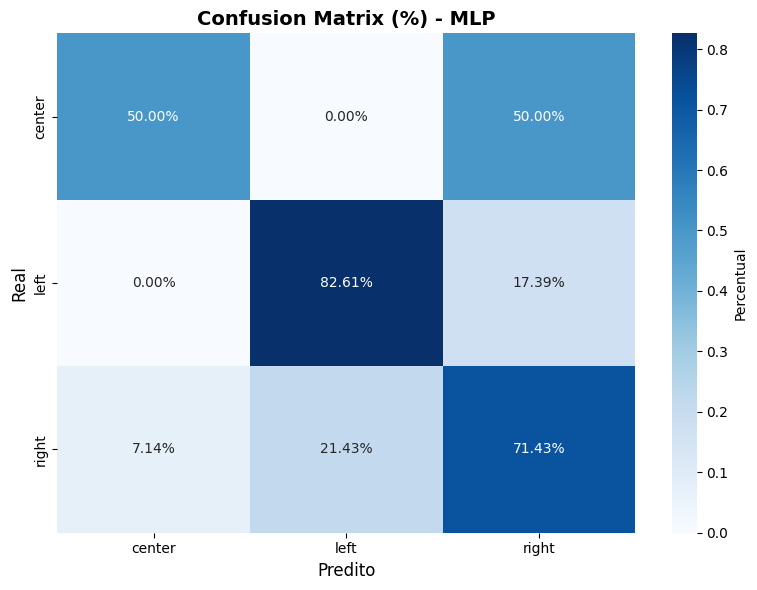

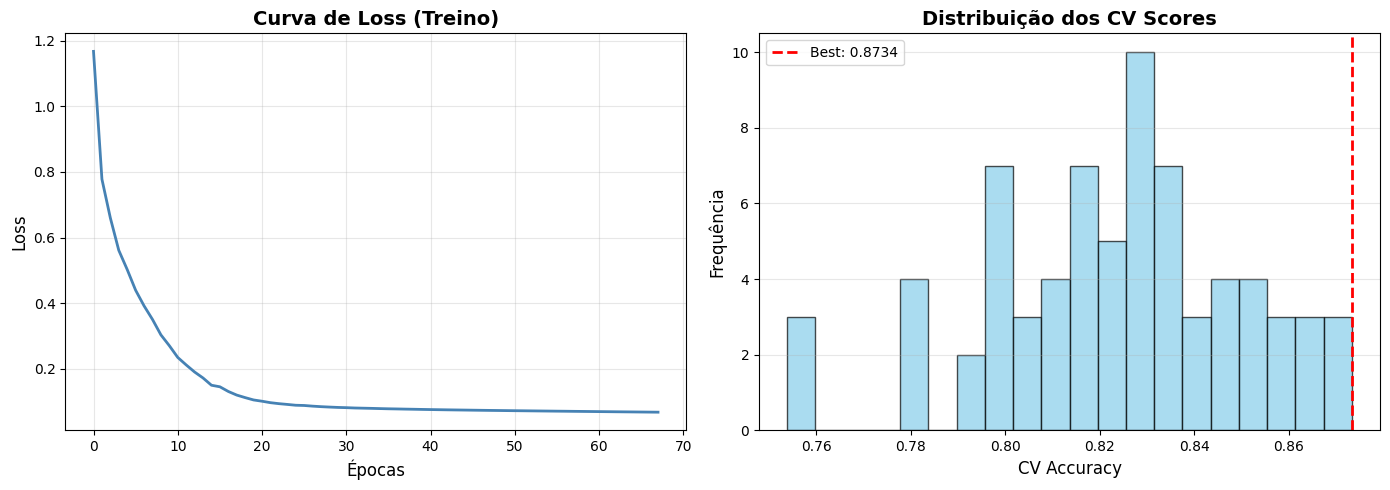

In [114]:
cv_results = pd.DataFrame(grid_search.cv_results_)

print(f"\nTOP 5 CONFIGURAÇÕES:")
top_5 = cv_results.nlargest(5, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
]
for idx, row in top_5.iterrows():
    print(f"\nRank {row['rank_test_score']}:")
    print(f"   Params: {row['params']}")
    print(f"   CV Score: {row['mean_test_score']:.4f} (+/- {row['std_test_score']:.4f})")


print(f"\nTreinando modelo FINAL com melhores hiperparâmetros...")

best_mlp = MLPClassifier(
    **grid_search.best_params_,
    activation='relu',
    solver='adam',
    max_iter=2000,          
    random_state=27,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=30,      
    verbose=True             
)

best_mlp.fit(X_train_scaled, y_train)

print(f"\nTreinamento final completo!")
print(f"   Iterações: {best_mlp.n_iter_}")
print(f"   Loss final: {best_mlp.loss_:.4f}")


y_pred = best_mlp.predict(X_test_scaled)
y_pred_proba = best_mlp.predict_proba(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_pred)

print(f"\n{'='*70}")
print(f"AVALIAÇÃO FINAL NO TESTE")
print(f"{'='*70}")
print(f"Accuracy: {test_accuracy:.4f}")

print(f"\nClassification Report:")
print(classification_report(
    y_test, 
    y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Contagem'}
)
plt.title('Confusion Matrix - MLP (Best Model)', fontsize=14, fontweight='bold')
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_percent, 
    annot=True, 
    fmt='.2%', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Percentual'}
)
plt.title('Confusion Matrix (%) - MLP', fontsize=14, fontweight='bold')
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.tight_layout()


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(best_mlp.loss_curve_, linewidth=2, color='steelblue')
axes[0].set_xlabel('Épocas', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Curva de Loss (Treino)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# CV scores
cv_scores_all = cv_results['mean_test_score']
axes[1].hist(cv_scores_all, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(grid_search.best_score_, color='red', linestyle='--', 
                linewidth=2, label=f'Best: {grid_search.best_score_:.4f}')
axes[1].set_xlabel('CV Accuracy', fontsize=12)
axes[1].set_ylabel('Frequência', fontsize=12)
axes[1].set_title('Distribuição dos CV Scores', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

print(f"\nANÁLISE POR CLASSE:")
for i, label in enumerate(label_encoder.classes_):
    mask = y_test == i
    acc = accuracy_score(y_test[mask], y_pred[mask])
    n_samples = mask.sum()
    print(f"   {label:8s}: {acc:.4f} ({n_samples} amostras)")

Vamos salvar os modelos

In [117]:
joblib.dump(best_mlp, 'models/mlp_best_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')
joblib.dump(grid_search, 'models/grid_search_results.pkl')

['models/grid_search_results.pkl']

## Resultados

### Modelo: MLP com SMOTE
- **Arquitetura**: 3 camadas (256, 128, 64 neurônios)
- **Accuracy**: 76.92%
- **CV Score**: 87.34% (±3.9%)

### Performance por Classe:
- **LEFT**: 82.61% (19/23 corretas)
- **RIGHT**: 71.43% (10/14 corretas)
- **CENTER**: 50.00% (1/2 corretas)

### Insights:
1. SMOTE foi essencial para balancear classes
2. Modelo confunde CENTER com RIGHT (ambos frontais)
3. LEFT tem boa separabilidade
